# ECI 2018 Lab 1: Linear encoding models for responses to speech # 

Author: Liberty Hamilton

This jupyter notebook tutorial will explain how to calculate linear receptive field models and time-delayed linear models for spectrotemporal, phonetic feature models, and semantic models. 

## How to use this notebook: ## 

Run through 

**References:**

* Aertsen & Johannesma (1981). The spectro-temporal receptive field.  Biological Cybernetics 42, 133-143. http://hearingbrain.org/docs/AertsenSTRF_1981.pdf
* Theunissen, David, Singh et al. (2001). Estimating spatio-temporal receptive fields of auditory and visual neurons from their responses to natural stimuli. Network 2001, 12:3 289-316. http://www.maths.tcd.ie/~mnl/store/TheunissenEtAl2001a.pdf
* Wu, David, Gallant (2006). Complete functional characterization of sensory neurons by system identification.  Annu Rev Neurosci 29: 477-505. http://suns.mit.edu/2006.Wu.David.Gallant.pdf

## What is a spectrotemporal receptive field?
A spectrotemporal receptive field is a linear filter that describes which spectrotemporal features of a stimulus will increase or decrease activity in a neuron/electrode/recording site.  

## Ridge regression (in general) ##

The goal of ridge regression is to find a linear transformation of your feature matrix, $X$, that best approximates your observed data, $Y$. The linear transformation takes the form of a weight matrix, $B$, such that $X B = Y$.

In ridge regression, $B$ is obtained by taking the ridge pseudoinverse of $X$ and multiplying it by $Y$ ($\hat{B} = X^+ Y$). To get the ridge pseudoinverse we first take the singular value decomposition (SVD) of $X$: $X = U S V^T$. For a normal pseudoinverse we would just invert the singular values (forming the inverse matrix $D$ by taking $1/S$ for each entry in $S$), but for a ridge pseudoinverse we regularize the inverse using a ridge penalty, $\alpha$. Thus we use $D_i = \frac{S_i}{(S_i^2 + \alpha^2)}$. This fixes problems with very small singular values, which would get very large in the inverse and mess things up.  Thus,

$X=U S V^T$ (this is the SVD of $X$)

or

$X = V S^2 V^T$ (for eigenvalue decomposition)

$X^+ = V D U^T $, where

$D_i = \frac{S_i}{(S_i^2 + \alpha^2)}$

The key issue for doing ridge regression is choosing the right $\alpha$. For real-world data (which is autocorrelated and messy), this is usually done by testing many different possible values of a using cross validation. In cross validation the regression dataset is broken up into two parts, a training set and a test set. A separate weight matrix, $B$, is obtained for each value of a using the training set, and then that $B$ is used to predict the test set. 

Weight estimates: $\hat{B} = X^+ Y$

$\hat{B} = V D(\alpha) U^T Y$

New prediction:

$\begin{eqnarray}
\hat{Y_{\mbox{held out}}} &=& X_{\mbox{held out}}\hat{B}\\
&=& X_{\mbox{held out}} V D(\alpha) U^T Y\\
&=& (X_{\mbox{held out}} V) D(\alpha) (U^T Y)
\end{eqnarray}$

This process is usually repeated a few times for a few different selections of training and test set. Then the best $\alpha$ is selected based on how well each $\alpha$ could be used to predict the test set.  


## The tutorial!

To use your own data, you will need:

- Your stimulus matrix (time x features).  This might be a spectrogram (time points x frequency bands, for example), or it might be a binary matrix for the presence/absence of phonemes or phonetic features (in that case, time points x  phonemes). It could also be just one feature you want to test (e.g. pitch, so the stimulus would be time points x 1 pitch channel).
- Your response matrix (time x electrodes).  This is your preprocessed, z-scored high gamma analytic amplitude. 
- The file should also contain the sampling rate of the data as a variable "fs" (Here fs=100)

### Sample data: ###

We include data from several sources:

1. Electrocorticography data from a person listening to sentences from the TIMIT database: <tt>data/EC63_stimresp.hf5</tt>
2. A fake dataset of simulated data: <tt>data/fakedata_stimresp.hf5</tt>.


In [23]:
# Import the modules we need, do some magic

# The first two lines here are a bit of "magic" for showing plots inline in the notebook
# (instead of opening a new window)
%pylab
%matplotlib inline

import tables # this is a library for loading hdf5 files
import scipy.io # For loading .mat files (usually from matlab)
import matplotlib.pyplot as plt # For plotting

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [28]:
# Choose which of these data files to use
use_fake_data = True
model_type = 'spectrotemporal'
fit_phoneme_model = True

if use_fake_data:
    dataFile = 'data/fakedata_stimresp.hf5' # Fake data
else:
    dataFile = 'data/EC63_stimresp.hf5' # HDF5 file with our data in two variables called "/audstim" and "/resp"

with tables.open_file(dataFile) as tf: # open the data file
    stim = tf.root.audstim.read() # Load the spectrogram matrix
    phnstim = tf.root.phnstim.read() # Load the binary phoneme presence/absence matrix (can use as stim instead)
    resp = tf.root.resp.read() # Loads the high gamma data matrix 
    fs = tf.root.fs.read() # Sampling rate of the data

nchans = resp.shape[1] # The number of channels (e.g. electrodes, neurons)

# Let's look at the dimensions of the stimulus matrix
print("Data file: %s"%(dataFile))
print("Data file", dataFile)
print("Spectrogram stimulus is %d time points x %d features"%(stim.shape))
print("Phoneme stimulus is %d time points x %d phonemes"%(phnstim.shape))
print("Response is %d time points x %d channels"%(resp.shape))

Data file: data/fakedata_stimresp.hf5
Data file data/fakedata_stimresp.hf5
Spectrogram stimulus is 10000 time points x 40 features
Phoneme stimulus is 10000 time points x 40 phonemes
Response is 10000 time points x 2 channels


## Plot the stimulus and response

At this point, it's helpful to show what the stimuli and responses look like so we know what will go into our model.  You should also check that nothing is weird with your spectrograms, and that trials with artifacts have been removed.

In [29]:
# Run this if you have a Retina or high resolution display, otherwise comment out
%config InlineBackend.figure_format = 'retina' 

In [35]:
# Z-score the response
# Make a zscoring function
zs = lambda x: (x-x.mean(0))/x.std(0) 

respz = zs(resp)

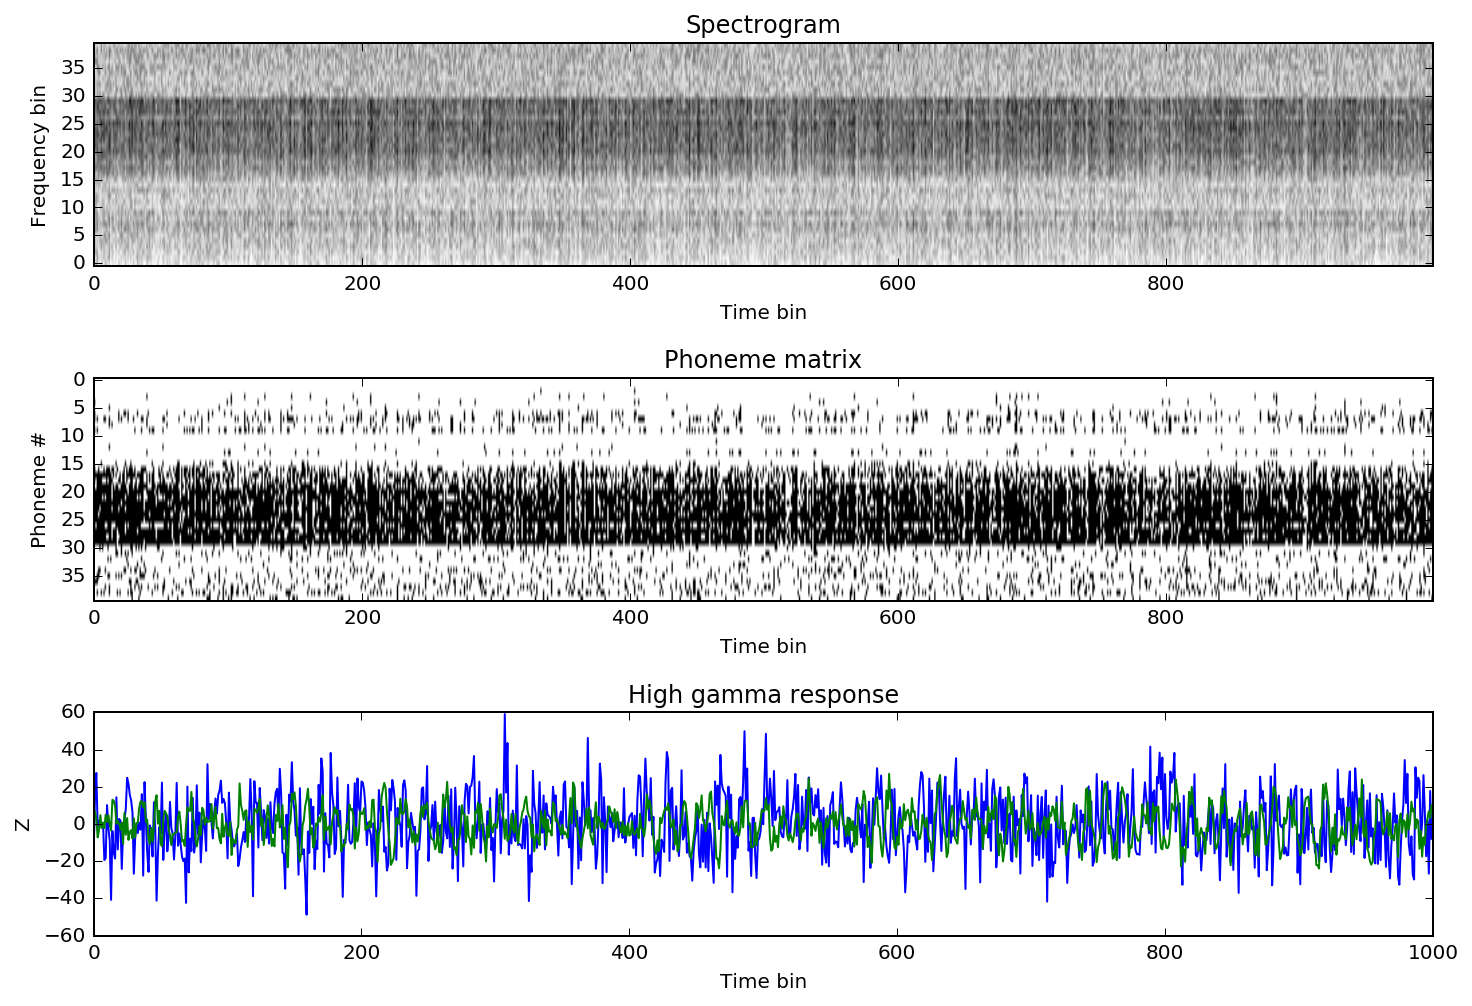

In [36]:
# Plot the stimulus and response to see what they look like

# Instead of plotting all ~100,000 time points, let's just plot a subset to get an idea
fig, axes = plt.subplots(figsize=(12,8)) # make a figure of size 12 x 8
ax = fig.add_subplot(3,1,1)
plt.imshow(stim[:1000,:].T, cmap = cm.Greys, aspect='auto') # I transposed the matrix so time is on the x axis
ax.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom
xlabel('Time bin')
ylabel('Frequency bin')
title('Spectrogram')

subplot(3,1,2)
plt.imshow(phnstim[:1000,:].T, cmap = cm.Greys, aspect='auto') # I transposed the matrix so time is on the x axis
xlabel('Time bin')
ylabel('Phoneme #')
title('Phoneme matrix')

subplot(3,1,3)
if nchans>4: # For a large number of channels, show an image
    plt.imshow(resp[:1000,:].T, vmin=-4, vmax=4, cmap = cm.RdBu_r, aspect='auto', interpolation = 'none') 
    ylabel('Electrode')
else: # For a small number of channels, plot the time series
    plt.plot(resp[:1000,:]) 
    ylabel('Z')
xlabel('Time bin')
title('High gamma response')

fig.subplots_adjust(hspace=.5) # Put some space between the plots for ease of viewing

# Set some parameters for this and future plots
rcParams['font.family'] = 'sans-serif'
rcParams['text.usetex'] = False
rcParams['axes.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10

savefig("sample_stimresp.pdf")

## Regression schematic

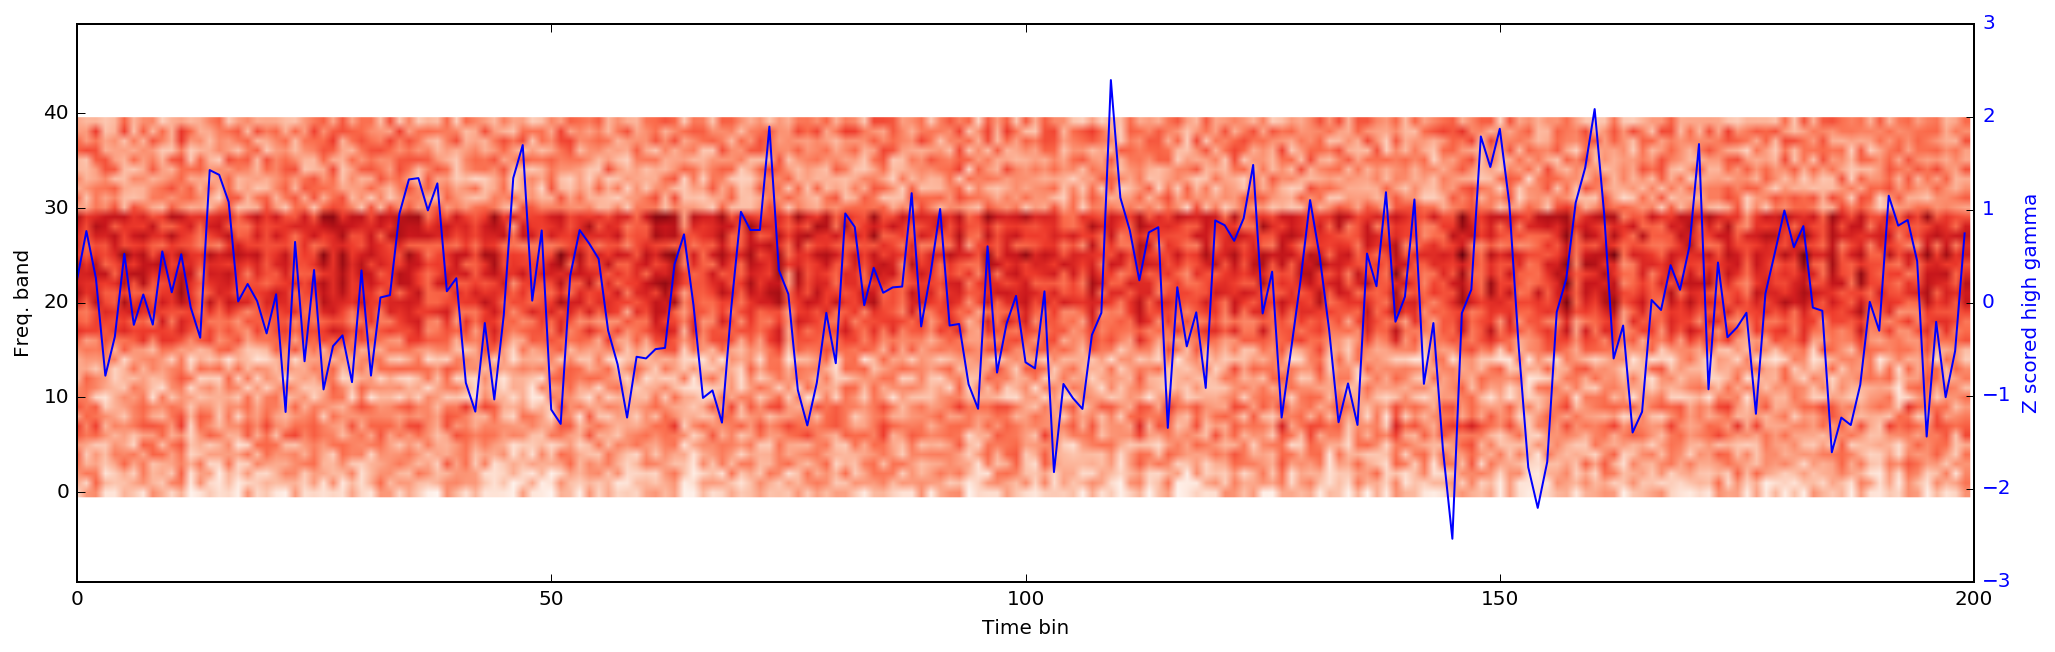

In [37]:
if not use_fake_data:
    chan_to_plot = 3# For EC63, also try 3, 18, 100
else:
    chan_to_plot = 1

ntimes = 200
fig = plt.figure(figsize=(17,5)) # make a figure of size 12 x 8
ax1 = fig.add_subplot(111)
ax1.imshow(stim[:ntimes,:].T, cmap = cm.Reds) # I transposed the matrix so time is on the x axis
#ax1.plot(stim[:ntimes,:].sum(axis=1), 'r')
xlabel('Time bin')
ax1.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom
ax1.set_ylabel('Freq. band')
ax1.set_xlim(0,ntimes)
ax1.set_ylim(0,stim.shape[1])

# Plot the response overlayed (with a separate y axis scaled appropriately)
ax2 = ax1.twinx()
ax2.plot(respz[:ntimes,chan_to_plot], 'b') 
ax2.set_ylabel('Z scored high gamma', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
ax2.set_xlim(0,ntimes);


## Create delay matrices

We now have the prerequisite matrices to perform our regression. If we want to include any time delays, we set up a stacked matrix of our stimulus at different time delays. This actually has a special name -- it's called a [Toeplitz matrix](http://en.wikipedia.org/wiki/Toeplitz_matrix)). As a toy example, say we have a spectrogram with 3 frequencies and n time points.  Our stacked delay matrix would look something like this:

$$
\begin{bmatrix}
                x_{1,1} & x_{1,2} & x_{1,3} & \ldots & x_{1,n} & 0 & 0 & 0& \ldots & 0 \\
                x_{2,1} & x_{2,2} & x_{2,3} & \ldots & x_{2,n} & 0 & 0 & 0& \ldots & 0 \\
                x_{3,1} & x_{3,2} & x_{3,3} & \ldots & x_{3,n} & 0 & 0 & 0& \ldots & 0 \\
                0 & x_{1,1} & x_{1,2} & x_{1,3} & \ldots & x_{1,n} & 0 & 0& \ldots & 0 \\
                0 & x_{2,1} & x_{2,2} & x_{2,3} & \ldots & x_{2,n} & 0 & 0& \ldots & 0 \\
                0 & x_{3,1} & x_{3,2} & x_{3,3} & \ldots & x_{3,n} & 0 & 0& \ldots & 0 \\
                0 & 0 & x_{1,1} & x_{1,2} & x_{1,3} & \ldots & x_{1,n} & 0& \ldots & 0 \\
                0 & 0 & x_{2,1} & x_{2,2} & x_{2,3} & \ldots & x_{2,n} & 0& \ldots & 0 \\
                0 & 0 & x_{3,1} & x_{3,2} & x_{3,3} & \ldots & x_{3,n} & 0& \ldots & 0 \\
                \vdots & \vdots & \vdots & \vdots & \vdots & \ldots & \vdots & \vdots  & \ldots & 0 \\
                0 & \ldots & 0 & 0 & x_{1,1} & \ldots & x_{1,n-2} & x_{1,n-1} & x_{1,n} & \vdots \\
                0 & \ldots & 0 & 0 & x_{2,1} & \ldots & x_{2,n-2} & x_{2,n-1} & x_{2,n} & \vdots \\
                0 & \ldots & 0 & 0 & x_{3,1} & \ldots & x_{3,n-2} & x_{3,n-1} & x_{3,n} & \vdots \\
                0 & \ldots & 0 & 0 & 0 & x_{1,1} & \ldots & x_{1,n-2} & x_{1,n-1} & x_{1,n} \\
                0 & \ldots & 0 & 0 & 0 & x_{2,1} & \ldots & x_{2,n-2} & x_{2,n-1} & x_{2,n} \\
                0 & \ldots & 0 & 0 & 0 & x_{3,1} & \ldots & x_{3,n-2} & x_{3,n-1} & x_{3,n}
            \end{bmatrix}.
$$

In [38]:
# If you want to use the phoneme stim, run the next line
if fit_phoneme_model:
    stim = phnstim

#stim = np.atleast_2d(stim.sum(axis=1))
#stim = stim.T
print(stim.shape)

# First, choose the number of delays to use (remember this is in bins)
delay_time = 0.6 # In seconds, how far back in the past to look (more delays = more time, more weights to fit, slower)
delays = np.arange(np.floor(delay_time*fs), dtype=np.int) 
#delays = [0] # Fit only the instantaneous model
print("Delays:", delays)

# Create the delay matrix
#stim = phnstim
zs = lambda x: (x-x.mean(0))/x.std(0)

# z-score the stimulus (if not a binary matrix, otherwise comment out)
if fit_phoneme_model:
    zstim = stim # don't z-score
else:
    zstim = zs(stim)

nt,ndim = zstim.shape # you could also replace all instances of "stim" here with "phnstim"
dstims = []
for di,d in enumerate(delays):
    dstim = np.zeros((nt, ndim))
    if d<0: ## negative delay
        dstim[:d,:] = zstim[-d:,:] # The last d elements until the end
    elif d>0:
        dstim[d:,:] = zstim[:-d,:] # All but the last d elements
    else:
        dstim = zstim.copy()
    dstims.append(dstim)
dstims = np.hstack(dstims)
print("Stimulus matrix is now %d time points by %d features (should be # original features \
(%d) x # delays (%d))"%(dstims.shape[0], dstims.shape[1], stim.shape[1], len(delays)))

(10000, 40)
Delays: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59]
Stimulus matrix is now 10000 time points by 2400 features (should be # original features (40) x # delays (60))


## Look at delayed stimulus matrix

Here I'll plot only a subset of the delayed matrix so you can see its structure. Again, this is transposed so that time is on the x axis. Red lines are shown so you can appreciate the small shifts of the matrices as a function of delay.

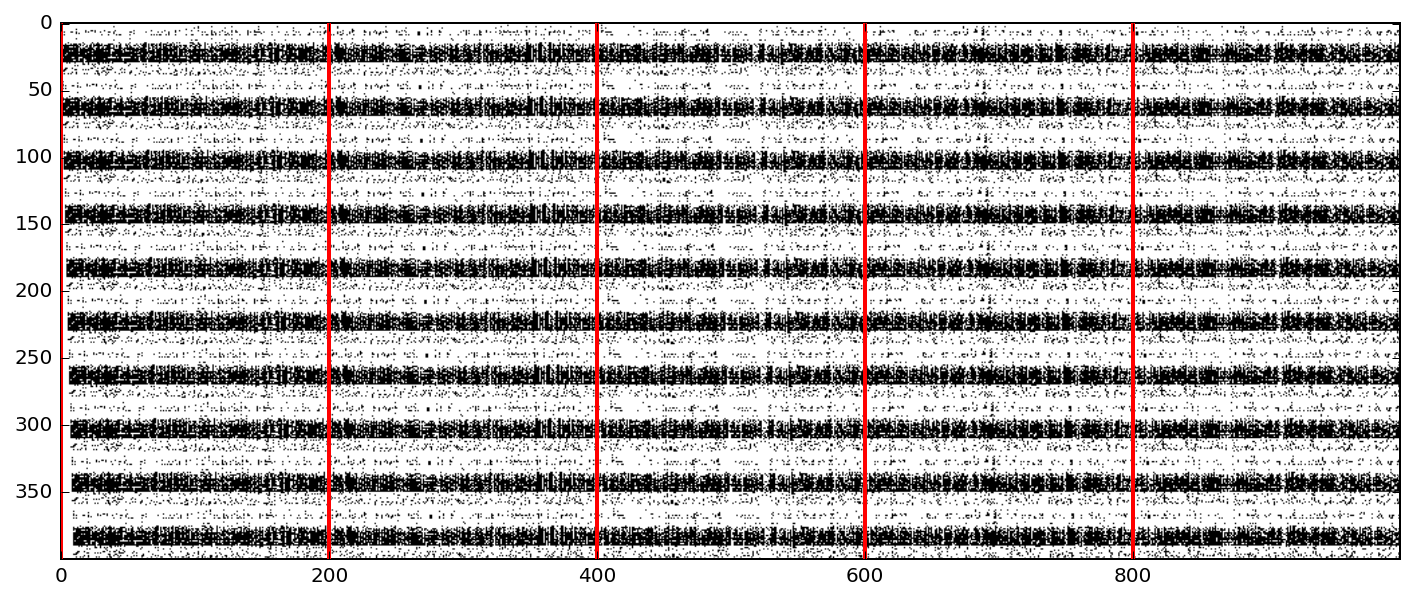

In [39]:
fig, axes = plt.subplots(figsize=(12,8))
imshow(dstims[:1000,:400].T, cmap = cm.Greys)
gca().xaxis.grid(b=True, which='major', color='r', linestyle='-', linewidth=2)

Here is the whole thing for comparison (still only the first 1000 time points, otherwise this plot is unwieldy.)  The delay structure is much easier to see here, but the fine structure of the individual spectrograms is gone.

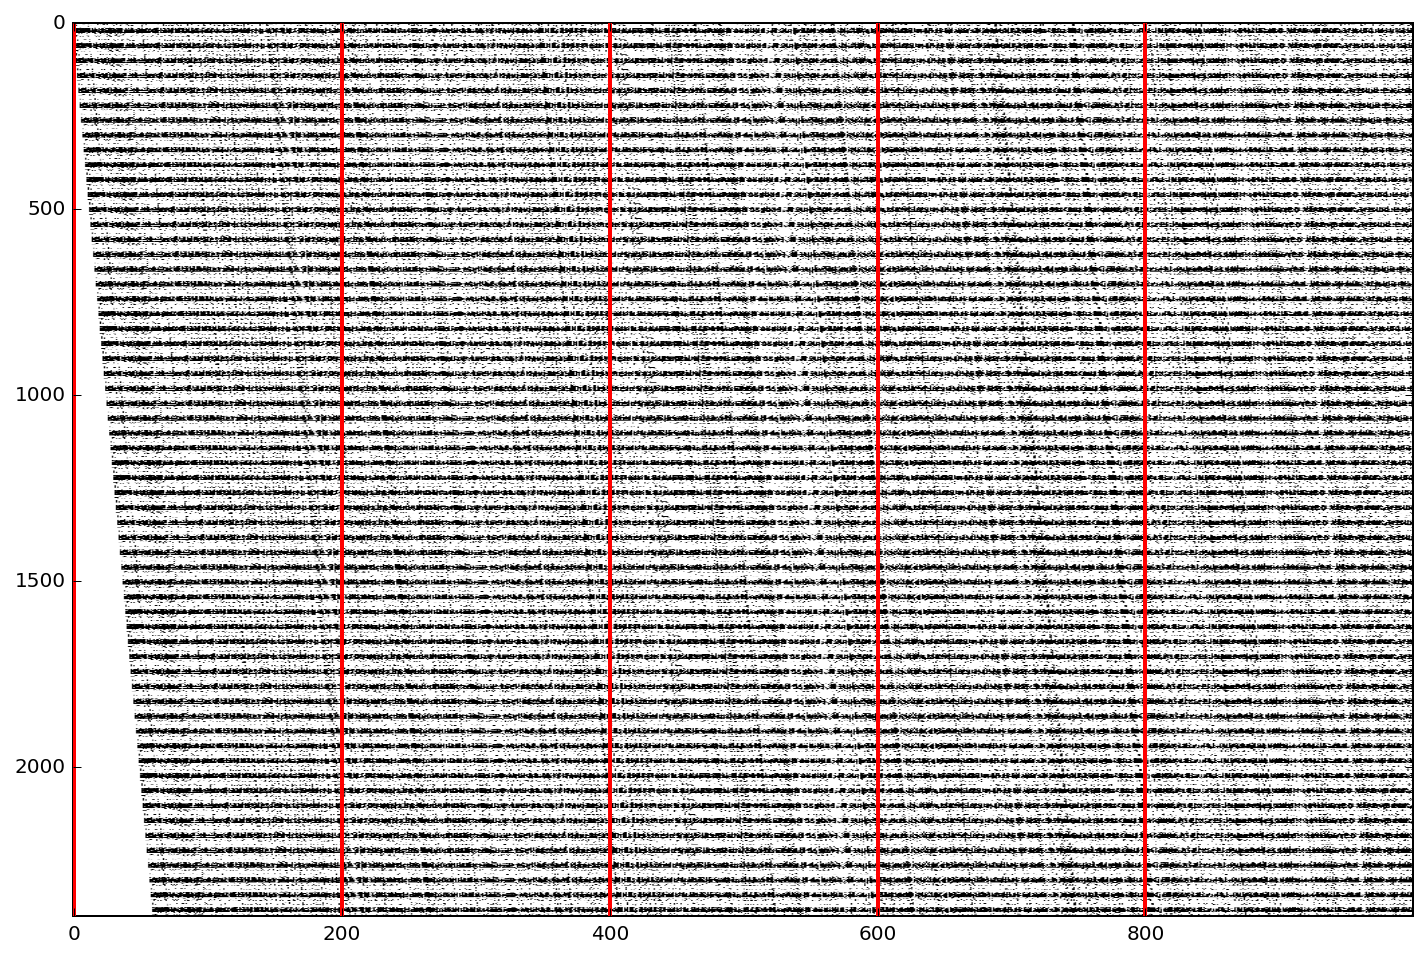

In [40]:
fig, axes = plt.subplots(figsize=(12,8))
imshow(dstims[:1000,:].T, cmap = cm.Greys, aspect='auto')
gca().xaxis.grid(b=True, which='major', color='r', linestyle='-', linewidth=2)

## Setting up the regression models - cross validation

Now that we have this stacked delay matrix, we split the data into chunks for cross validation -- 60% of the data is used for training, 20% to calculate the ridge parameter, and 20% for our final validation.  It is good practice to try different partitions of the data for training, ridge, and validation to determine the stability of your solution and to get bounds on the correlation coefficients.

In [44]:
# Training indices
train_inds = np.arange(np.int(nt*0.6))

# Ridge indices
ridge_inds = np.arange(np.int(nt*0.6),np.int(nt*0.8))

# Validation indices
val_inds = np.arange(np.int(nt*0.8),nt)

print("Delayed stimulus matrix has dimensions", dstims.shape)

# Create matrices for cross validation
tStim = dstims[train_inds,:]
tResp = resp[train_inds,:]
tResp_z = respz[train_inds,:]
rStim = dstims[ridge_inds,:]
rResp = resp[ridge_inds,:]
rResp_z = respz[ridge_inds,:]
vStim = dstims[val_inds,:]
vResp_z = respz[val_inds,:]

Delayed stimulus matrix has dimensions (10000, 2400)


## Covariance matrix

In most STRF analyses, we must normalize by autocorrelations in the stimulus (frequencies that always appear together, or temporal correlations that occur as a result of smoothly varying signals).  We do this by calculating the covariance of the delayed stimulus.  This will tell us which frequencies/features covary with one another in our stimulus, and how they covary across time (that is, is "f" often followed by "aa" 10 ms later?)

In [45]:
# Calculate covariance matrix for training data
dtype = np.single
covmat = np.array(np.dot(tStim.astype(dtype).T, tStim.astype(dtype)))

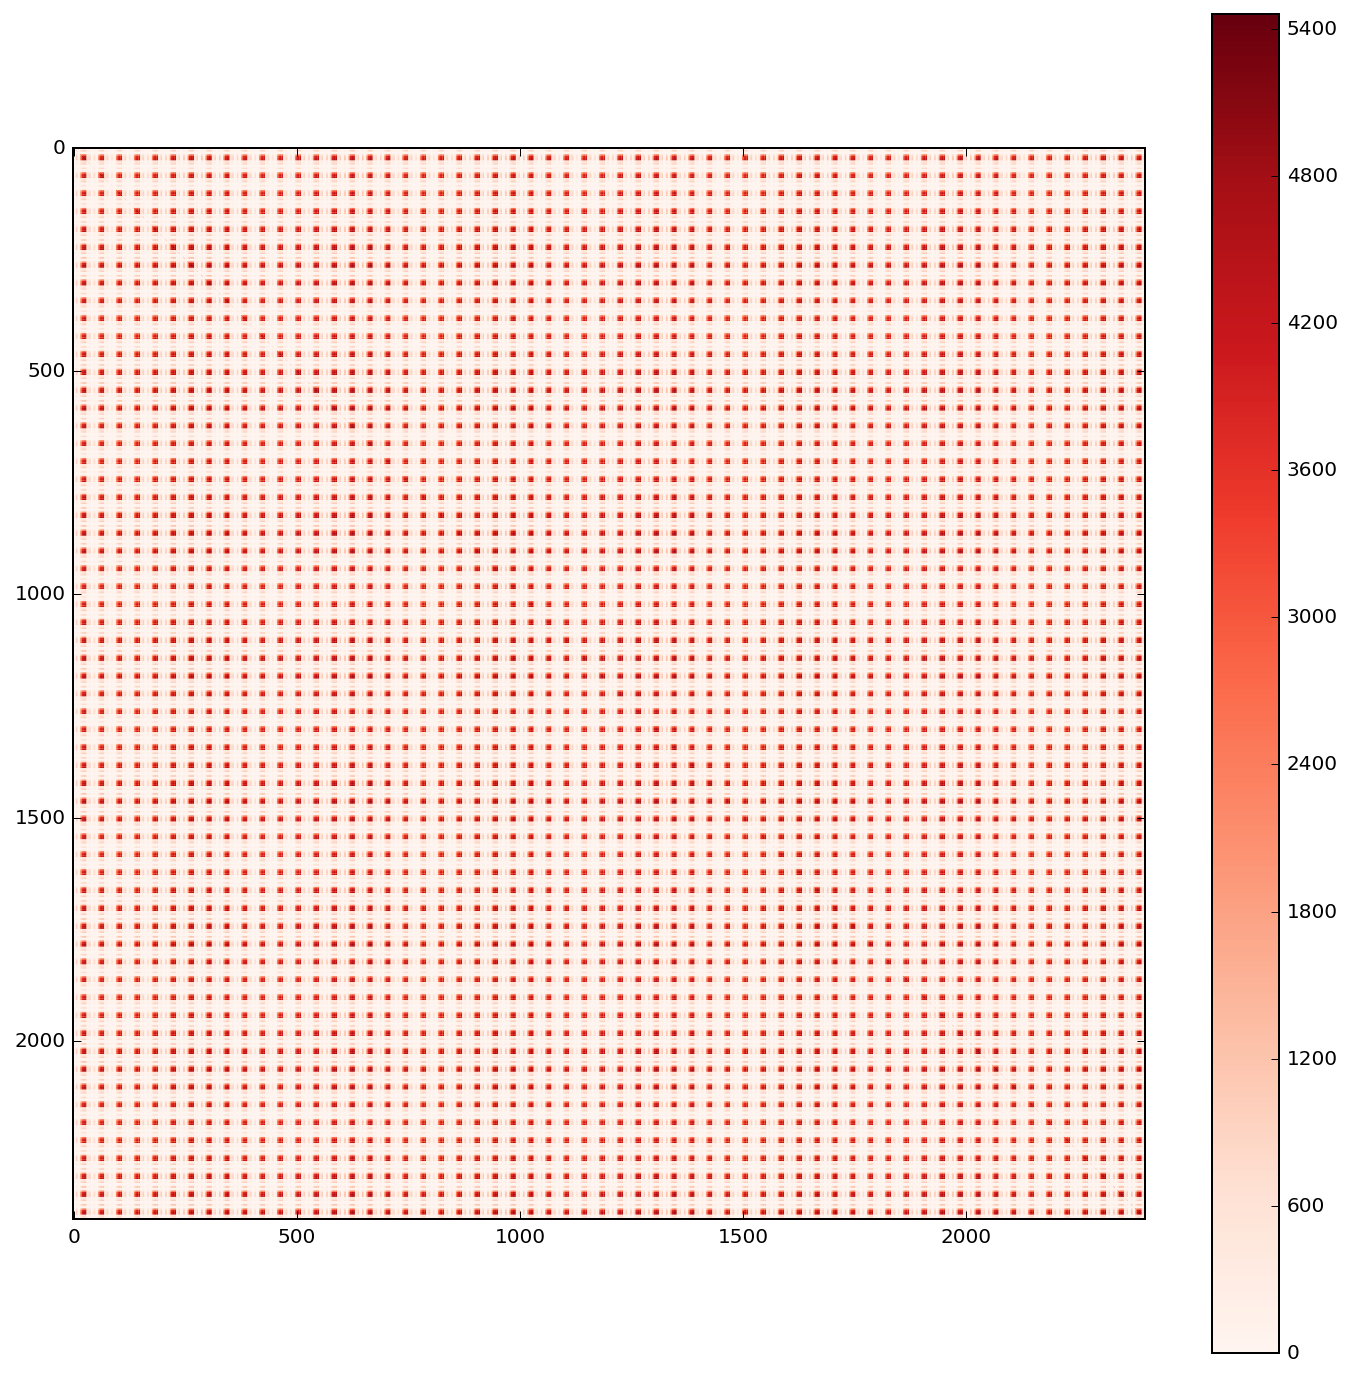

In [46]:
# Show covariance matrix
figure(figsize=(12,12))
imshow(covmat, cmap=cm.Reds)
colorbar()

In [49]:
# Do eigenvalue decomposition on the covariance matrix
[S,U] = np.linalg.eigh(covmat)

# eigenvalues are squared singular values S=sigma^2
Usr = np.dot(U.T, np.dot(tStim.T, tResp))

# Set the regularization values that you are going to test
# Usually this will be 0 (for no regularization), then some wide range of values.
# Here we're testing 15 values, log-spaced between 10^2 and 10^8
alphas = np.hstack((0,np.logspace(2,8,15)))

nalphas = len(alphas)
wts = []
Rcorrs = []
bestcorr = -1.0
corrmin = 0.1

for i, a in enumerate(alphas):
    print("Running alpha %0.3f"%a)
    D = np.diag(1/(S+a)).astype(dtype)
    wt = np.array(np.dot(U, np.dot(D, Usr)).astype(dtype))

    print(U.shape, D.shape, Usr.shape)
    ## Predict test responses
    pred = np.dot(rStim, wt) # predicted response
    # calculate correlation between actual response in ridge set and predicted response
    Rcorr = np.array([np.corrcoef(rResp[:,ii], np.array(pred[:,ii]).ravel())[0,1] for ii in range(rResp.shape[1])]) ## Slowly compute correlations
    Rcorr[np.isnan(Rcorr)] = 0
    Rcorrs.append(Rcorr)
    
    wts.append(wt)
    print("Training: alpha=%0.3f, mean corr=%0.3f, max corr=%0.3f, over-under(%0.2f)=%d"%(a, np.mean(Rcorr), np.max(Rcorr), corrmin, (Rcorr>corrmin).sum()-(-Rcorr>corrmin).sum()))
    
# wts matrix is the matrix of STRFs for each alpha value
wts = np.array(wts)
# Rcorrs is the matrix of correlations on the ridge set
Rcorrs = np.array(Rcorrs)

print(Rcorrs.shape)
#plt.plot(Rcorrs)

Running alpha 0.000
(2400, 2400) (2400, 2400) (2400, 2)
Training: alpha=0.000, mean corr=0.000, max corr=0.000, over-under(0.10)=0
Running alpha 100.000
(2400, 2400) (2400, 2400) (2400, 2)
Training: alpha=100.000, mean corr=0.335, max corr=0.534, over-under(0.10)=2
Running alpha 268.270
(2400, 2400) (2400, 2400) (2400, 2)
Training: alpha=268.270, mean corr=0.356, max corr=0.560, over-under(0.10)=2
Running alpha 719.686


/Users/liberty/anaconda3/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


(2400, 2400) (2400, 2400) (2400, 2)
Training: alpha=719.686, mean corr=0.376, max corr=0.578, over-under(0.10)=2
Running alpha 1930.698
(2400, 2400) (2400, 2400) (2400, 2)
Training: alpha=1930.698, mean corr=0.390, max corr=0.583, over-under(0.10)=2
Running alpha 5179.475
(2400, 2400) (2400, 2400) (2400, 2)
Training: alpha=5179.475, mean corr=0.396, max corr=0.579, over-under(0.10)=2
Running alpha 13894.955
(2400, 2400) (2400, 2400) (2400, 2)
Training: alpha=13894.955, mean corr=0.397, max corr=0.574, over-under(0.10)=2
Running alpha 37275.937
(2400, 2400) (2400, 2400) (2400, 2)
Training: alpha=37275.937, mean corr=0.396, max corr=0.571, over-under(0.10)=2
Running alpha 100000.000
(2400, 2400) (2400, 2400) (2400, 2)
Training: alpha=100000.000, mean corr=0.396, max corr=0.570, over-under(0.10)=2
Running alpha 268269.580
(2400, 2400) (2400, 2400) (2400, 2)
Training: alpha=268269.580, mean corr=0.396, max corr=0.569, over-under(0.10)=2
Running alpha 719685.673
(2400, 2400) (2400, 2400) (2

Correlation matrix shape: (16, 2)


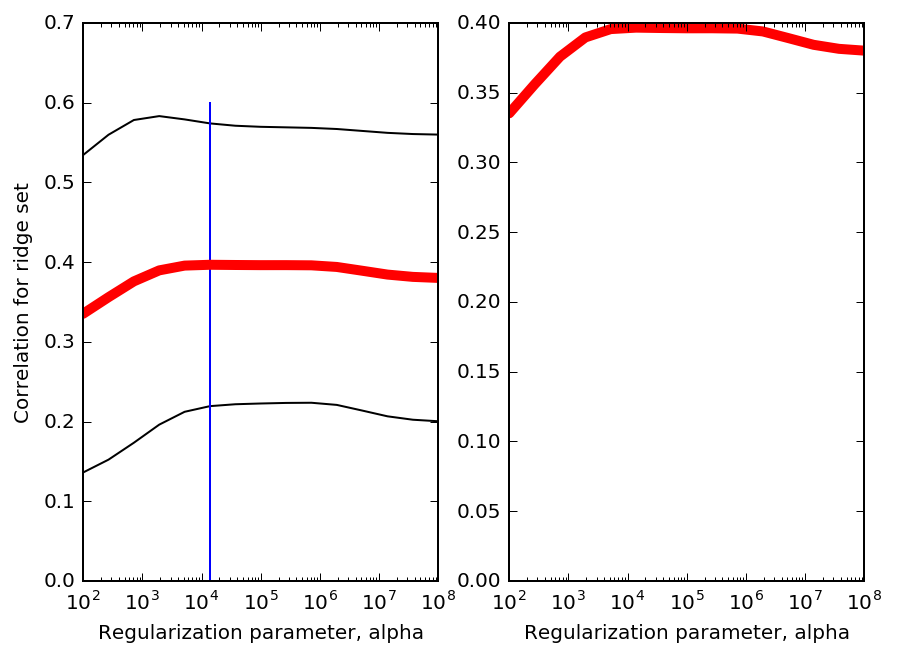

In [50]:
print("Correlation matrix shape:", Rcorrs.shape)

# Find the best alpha value to determine which regularization parameter should be used
best_alpha_overall = Rcorrs.mean(1).argmax() # Find the best alpha overall
best_alphas_indiv = Rcorrs.argmax(0) # Find the best alpha for each channel separately

# Plot correlations vs. alpha regularization value
fig=figure(figsize=(7,5))
fig.clf()
subplot(1,2,1)
plt.plot(alphas,Rcorrs,'k')
gca().set_xscale('log')

# Plot the best average alpha
plt.plot([alphas[best_alpha_overall], alphas[best_alpha_overall]],[ylim()[0],ylim()[1]])
plt.plot(alphas,np.array(Rcorrs).mean(1),'r',linewidth=5)
xlabel('Regularization parameter, alpha')
ylabel('Correlation for ridge set')

subplot(1,2,2)
plt.plot(alphas,np.array(Rcorrs).mean(1),'r',linewidth=5)
xlabel('Regularization parameter, alpha')
gca().set_xscale('log')


## Calculating performance on the validation set

Next, we need to calculate the predicted response to our validation set for our assessment of model performance.  Normally we would only do this for the best alpha found in the previous step, but here we will calculate all STRFs for all channels and all alphas so we can compare the correlations later.

In [51]:
print("Calculating predicted response to validation set")
wt_array = np.dstack(wts)
print(wt_array.shape)
vPred = [ [ vStim.dot(wt_array[:,ch,alph]) for ch in np.arange(nchans)] for alph in np.arange(nalphas)]
vPred = np.array(vPred)

Calculating predicted response to validation set
(2400, 2, 16)


In [52]:
print("Calculating correlations on validation set")
vcorr  = [ [ np.corrcoef(vPred[alph][ch], vResp[:,ch])[0,1] for ch in np.arange(nchans)] for alph in np.arange(nalphas)]
vcorr = np.array(vcorr)
print("Done calculating correlations")
print("Correlation matrix shape: ", vcorr.shape)

Calculating correlations on validation set
Done calculating correlations
Correlation matrix shape:  (16, 2)


## Plotting predicted vs. actual responses

Best electrode is channel 1 with r= 0.544320621874
Prediction matrix shape:  (16, 2, 2000)
Response matrix shape:  (2000, 2)


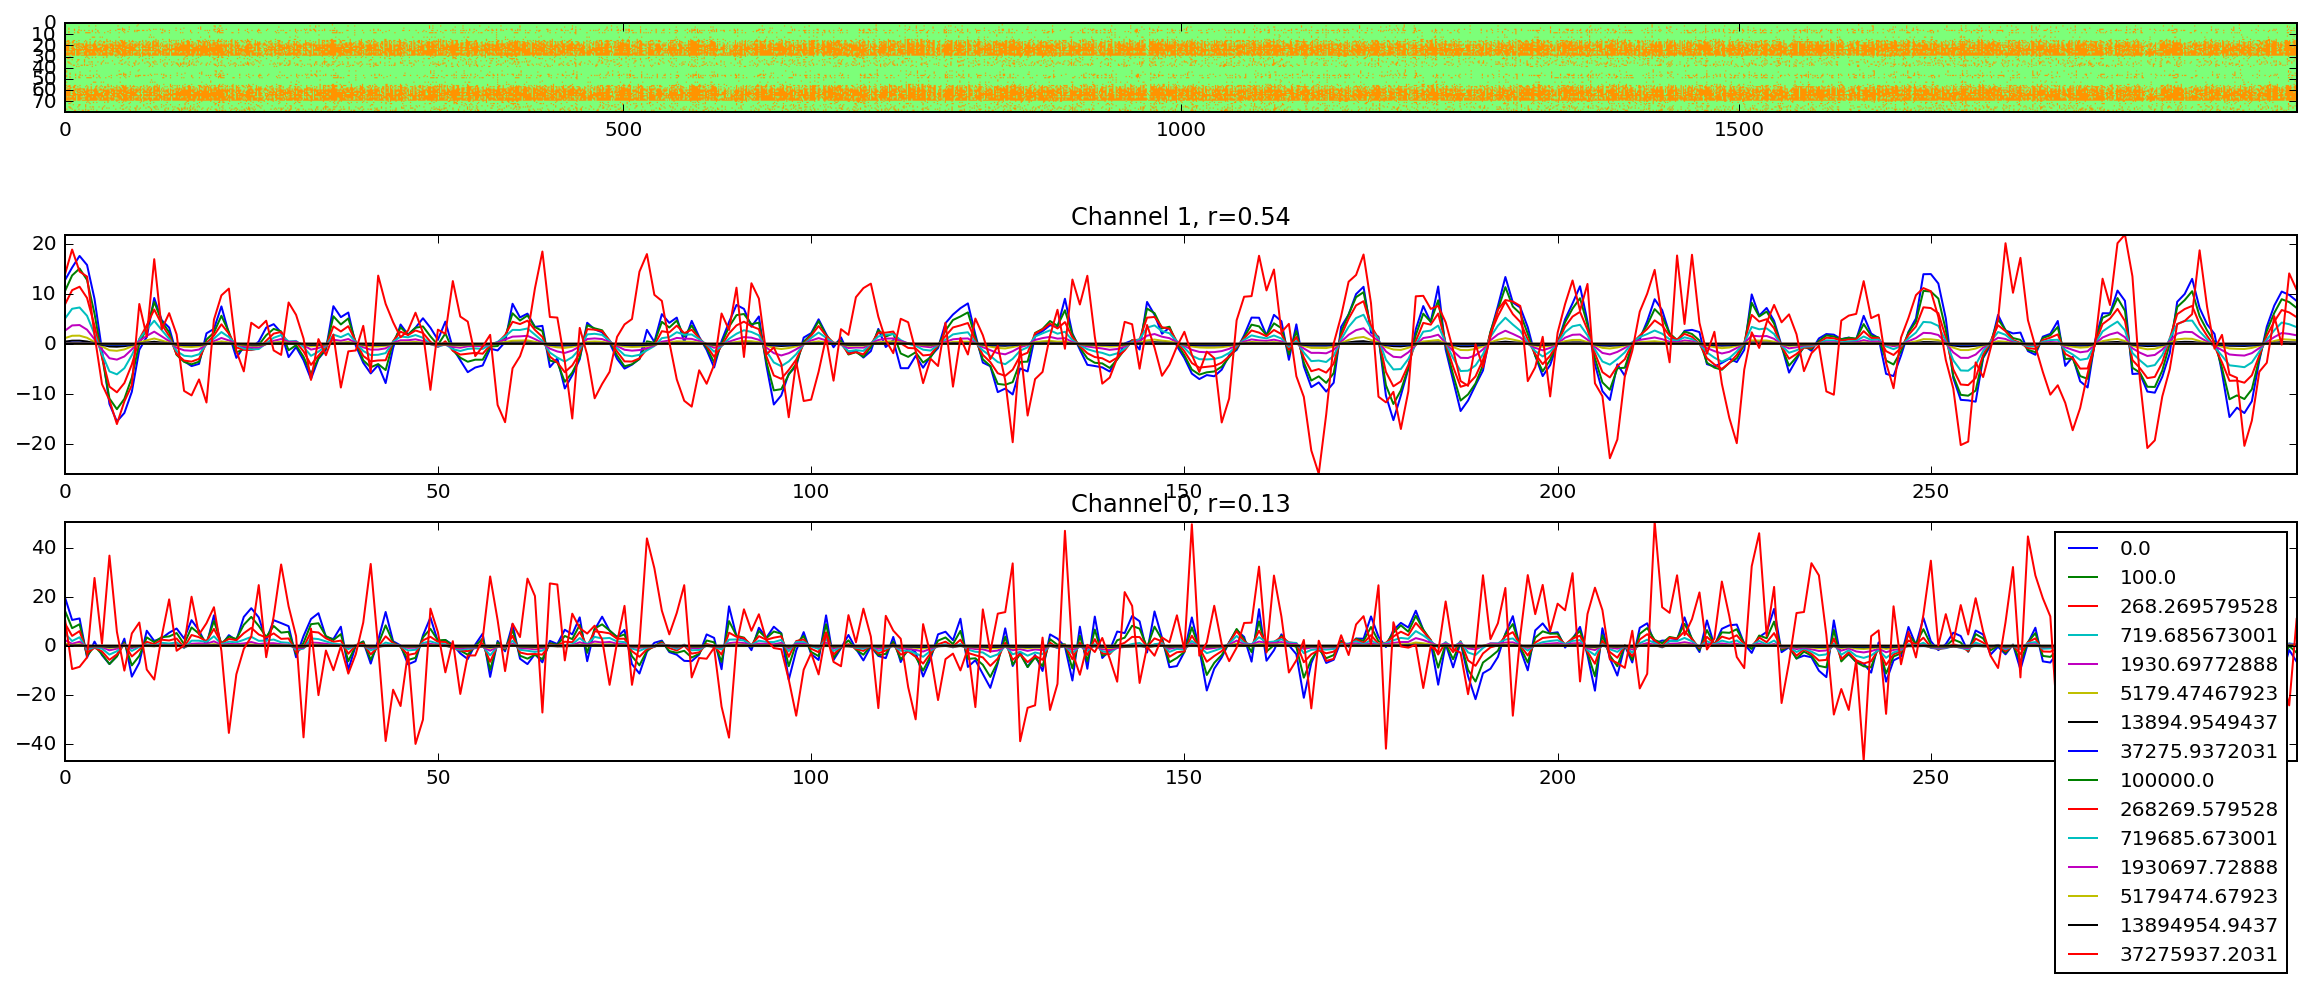

In [58]:
# Sort channels by highest validation correlation and plot the response predicted by the STRF 
# overlayed on the actual activity 
vcorr[np.isnan(vcorr)]=0
sorted_chans = vcorr.mean(0).argsort() # sort validation correlations by highest mean correlation across alpha value
best_chan = sorted_chans[-1]
print("Best electrode is channel", best_chan, "with r=", vcorr[:,best_chan].mean())
# Plot predictions vs. actual response
print("Prediction matrix shape: ", vPred.shape)
print("Response matrix shape: ", vResp.shape)

fig = figure(figsize=(20,15))
subplot(6,1,1)
imshow(vStim[:,0:80].T,vmin=-2,vmax=2)
for i in np.arange(2):
    subplot(6,1,i+2)
    plot(vPred[2:,sorted_chans[-(i+1)],:300].T)
    plot(vResp[:300,sorted_chans[-(i+1)]],'r')
    title('Channel %d, r=%2.2f'%(sorted_chans[-(i+1)], vcorr[:,sorted_chans[-(i+1)]].mean()))
    axis('tight')
legend(alphas)

## Visualizing the STRF filters

Here we will show the STRF filters we've derived for each channel.  These filters show which spectrotemporal features of the stimulus best predict an increase or decrease in the observed neural activity.

In [ ]:
# Plot all of the STRFs, using a separate regularization parameter for each (whichever gives the best performance)
if nchans>4:
    fsize=(15,15)
    nrow = np.sqrt(nchans)
    ncol = np.ceil(nchans/nrow)
else:
    fsize=(6,3)
    nrow = 1
    ncol = nchans

print(resp.shape)
fig = figure(figsize=fsize)
print(wt_array.shape)
# Use separate regularization parameters for each STRF
nchans = resp.shape[1]
for c in np.arange(nchans):
    ax = fig.add_subplot(nrow,ncol,c+1)
    strf = wt_array[:,c,best_alphas_indiv[c]].reshape(len(delays),-1)
    smax = np.abs(strf).max()
    imshow(strf.T, vmin=-smax, vmax=smax, cmap = cm.RdBu_r)
    title('r=%2.2f'%(vcorr[best_alphas_indiv[c], c]))
    if c==0:
        xlabel('Delay')
        ylabel('Freq.')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])


In [ ]:
# Use the same regularization parameters for each STRF
fig = figure(figsize=fsize)
for c in np.arange(nchans):
    ax = fig.add_subplot(nrow,ncol,c+1)
    strf = wt_array[:,c,best_alpha_overall].reshape(len(delays),-1)
    smax = np.abs(wt_array).max()
    imshow(strf.T,vmin=-smax, vmax=smax, cmap = cm.RdBu_r)
    title('r=%2.2f'%(vcorr[best_alpha_overall, c]))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    xlabel('Delay')
    ylabel('Phoneme')
    #colorbar()

## How does the selection of $\alpha$ affect the observed STRF filters? ##

It is important to choose a range of $\alpha$ values and determine which yield the best predictions on held out data, since the regularization parameter itself can affect the structure of your STRF.

In [ ]:
# Show how regularization parameter changes STRFs
fig = figure(figsize=(20,5))
fig.clf()
best_nchans = 2
axes = [fig.add_subplot(best_nchans,len(alphas),ii+1) for ii in range((len(alphas))*best_nchans)]
best_strf_inds = np.array(vcorr).mean(0).argsort()[::-1]
p = 0
for c in np.arange(best_nchans): # loop through the best channels
    ch = best_strf_inds[c]
    for a in np.arange(len(alphas)): # loop through the alpha regularization parameter
        strf = wt_array[:,ch,a].reshape(len(delays),-1)
        smax = np.abs(strf).max()
        axes[p].imshow(strf.T,vmin=-smax, vmax=smax, cmap = cm.RdBu_r) 
        axes[p].xaxis.set_ticks([])
        axes[p].yaxis.set_ticks([])
        axes[p].set_xlabel('r=%2.3f'%(np.array(vcorr)[a,ch]))
        p+=1

fig.subplots_adjust(hspace=.5)
        

In [ ]:
# Save the weights file
def save_table_file(filename, filedict):
    """Saves the variables in [filedict] in a hdf5 table file at [filename].
    """
    with tables.open_file(filename, mode="w", title="save_file") as hf:
        for vname, var in filedict.items():
            hf.create_array("/", vname, var)

wtfile = 'wts.hf5'
save_table_file(wtfile, dict(wts = wt_array, 
                             corrs = Rcorrs, 
                             vcorrs = vcorr, 
                             fs = fs, 
                             delays = delays, 
                             alphas = alphas))

print("Saved file to %s"%(wtfile))